In [1]:
import torchvision
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.supervised import Naive
from avalanche.models import SlimResNet18
from avalanche.benchmarks import with_task_labels, benchmark_from_datasets
from utils import load_CLEAR, build_CLEAR_train_experiences, build_CLEAR_test_experiences
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics
from avalanche.benchmarks.scenarios.online import split_online_stream
from avalanche.benchmarks.scenarios.supervised import with_classes_timeline, class_incremental_benchmark

/Users/marcodamommio/2023-2024_OCL_Class-Incremental/sda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
CLEAR_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            #normalize,
        ]
    )
train_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/train/labeled_images'
test_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/test/labeled_images'
train_dict = load_CLEAR(train_path, transform=CLEAR_transform)
test_dict = load_CLEAR(test_path, transform=CLEAR_transform)

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


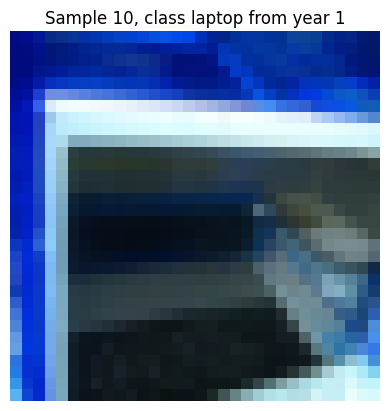

In [3]:
year_folder_name = '1'
class_folder_name = 'laptop'
images_array = test_dict[year_folder_name][class_folder_name]

elem = 10
plt.imshow(images_array[elem].permute(1,2,0))
plt.axis('off') 
plt.title(f'Sample {elem}, class {class_folder_name} from year {year_folder_name}')
plt.show()

In [4]:
classes_pairs = [
    ('BACKGROUND', 'baseball'),
    ('bus', 'camera'),
    ('cosplay', 'dress'),
    ('hockey', 'laptop'),
    ('racing', 'soccer'),
    ('sweater', None)   
]

In [5]:
train_experiences = build_CLEAR_train_experiences(train_dict, classes_pairs)
test_experiences = build_CLEAR_test_experiences(test_dict, classes_pairs)

In [6]:
bm = with_task_labels(
    benchmark_from_datasets(
        train=train_experiences,
        test = test_experiences
    ) 
)

In [7]:
experience_mb_size = 10
online_train_stream = split_online_stream(
    bm.train_stream,
    experience_size=experience_mb_size,
    shuffle=False
)

In [18]:
model = SlimResNet18(nclasses=11, nf=5)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
loggers = [InteractiveLogger()]
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=loggers
)
cl_strategy = Naive(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    train_mb_size=experience_mb_size,
    train_epochs=1, 
    eval_mb_size=32,
    evaluator=eval_plugin
)

 17%|█▋        | 100/600 [01:07<05:36,  1.49it/s]


In [19]:
bm.test_stream[0]

In [20]:
# TRAINING LOOP
print('Starting experiment...')
results = []
idx = 0
for experience in online_train_stream:
    print("Start of experience: ", experience.current_experience)
    print(f"\tsize: {len(experience.dataset)}")
    #print(f"Classes in this experience: {experience.classes_in_this_experience}")

    cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    #results.append(cl_strategy.eval(bm.test_stream))
    idx += 1
    if idx == 1200:
        break

Starting experiment...
Start of experience:  0
	size: 10
-- >> Start of training phase << --
-- Starting training on experience 0 from train_online stream --
  0%|          | 1/600 [00:00<00:14, 40.96it/s]-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
Start of experience:  1
	size: 10
-- >> Start of training phase << --
  0%|          | 2/600 [00:00<00:13, 45.46it/s]-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
Start of experience:  2
	size: 10
-- >> Start of training phase << --
  0%|          | 3/600 [00:00<00:13, 43.48it/s]-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
Start of experience:  3
	size: 10
-- >> Start of training phase << --
  1%|          | 4/600 [00:00<00:16, 36.97it/s]-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
Start of experience:  4
	size: 10
-- >> Start of training phase << -

In [21]:
metrics = eval_plugin.get_all_metrics()

In [22]:
print('\n'.join(list(metrics.keys())))

Top1_Acc_MB/train_phase/train_online_stream
Loss_MB/train_phase/train_online_stream


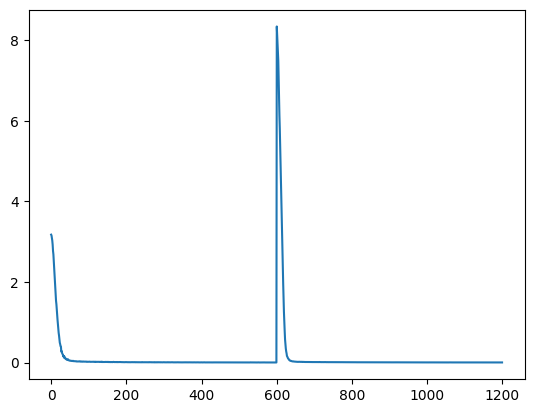

In [23]:
exp, loss = metrics['Loss_MB/train_phase/train_online_stream']
plt.plot(exp, loss)

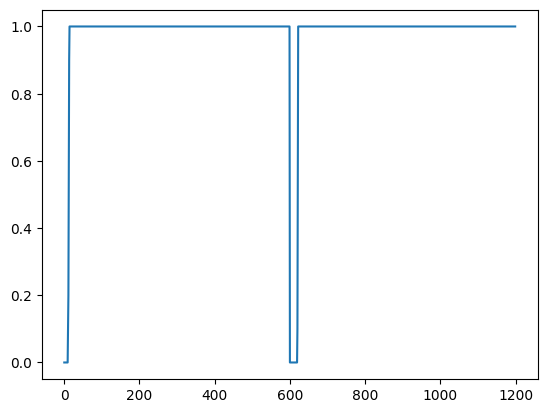

In [24]:
exp, acc = metrics['Top1_Acc_MB/train_phase/train_online_stream']
plt.plot(exp, acc)